# Repeat Buyers Prediction for E-Commerce

### Problem Statement
Merchants often gain many new customers through promotions, but a significant portion of these customers are only interested in one-time deals. Therefore, the impact of promotions on long-term sales may be limited. To maximize return on investment (ROI) and reduce promotion costs, it is crucial for merchants to distinguish between one-time buyers and potential loyal customers and focus their efforts on converting the latter group.

In this project, you are provided a dataset with information on promotional shopping event from e-commerce platform. Your task is to design a system which will increase the ROI (in other words, you need to predict the probability that these new buyers would purchase items from the same merchants again within 6 months), reduce promotional cost, and identify one-time buyers. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

user_logs = pd.read_csv('Dataset/user_log.csv')
user_profile = pd.read_csv('Dataset/user_info.csv')
train_df = pd.read_csv('Dataset/train.csv')
test_df = pd.read_csv('Dataset/test.csv')

In [2]:
user_logs.head()

user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type
0   219316      472     737        801    5890.0        1018            0
1    69247      471    1266       4614    4331.0         619            2
2    69247      471    1266       4614    4331.0         619            0
3   216952      352     991       3527     869.0         626            0
4   216952      352     991       3527     869.0         626            0

In [3]:
#user_logs contains all the data from item id: 321 -480
print("maximum item id :" + str(user_logs['item_id'].max()))
print("minimum item id :" + str(user_logs['item_id'].min()))

maximum item id :480
minimum item id :321


In [4]:
#size of user logs dataset
user_logs.shape

(7402, 7)

In [5]:
#Duplicate records found in userlog dataset
user_logs.duplicated().sum()

2033

# Data Visualization

4 Data Frames 

**User Behavior**, with 6 columns, *user_id*: a unique id for the shopper, *item_id*: a unique id for the item, *cat_id*, a unique id for the category that the item belongs to, *merchant_id*: a unique id for the merchant, *brand_id*: a unique id for the brand of the item, *time_stamp*: date the action took place (format: mmdd), and *action_type*: it is an enumerated type {0, 1, 2, 3}, where 0 is for click, 1 is for add-to-cart, 2 is for purchase and 3 is for add-to-favorite. 

**User Profile**, with 3 columns, *user_id*: a unique id for the shopper, *age_range*: user's age range, 1 for younger than 18, 2 for 18-24, 3 for 25-29, 4 for 30-34, 5 for 35-39, 6 for 40-49, 7 and 8 for older than 50, and 0 and Null for unknown, and *gender*: user's gender, 0 for female, 1 for male, and 2 for Null or unknown. 

**Training and Testing**, *user_id*: a unique id for the shopper, *merchant_id*: a unqiue id for the merchant, and *label*: it is an enumerated type{0, 1}, where 1 means repeat buyer, 0 is for non-repeat buyer. This field is blank for test data.

### Bar Charts

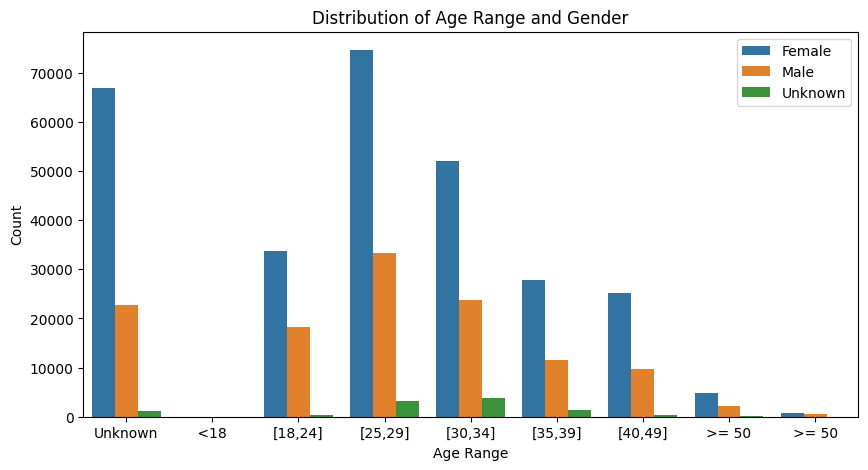

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(x='age_range', hue='gender', data=user_profile)
plt.title('Distribution of Age Range and Gender')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(['Female', 'Male', 'Unknown'])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ["Unknown", " <18 ", "[18,24]", "[25,29]", "[30,34]", "[35,39]", "[40,49]", ">= 50", ">= 50"])
plt.show()

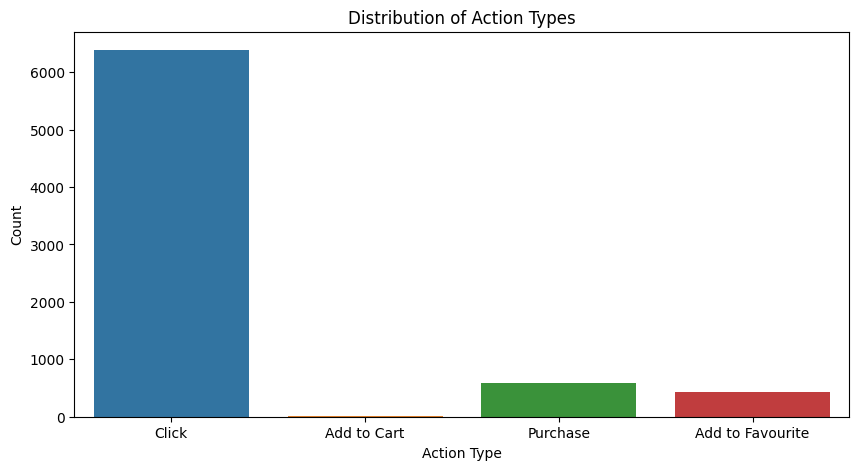

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x='action_type', data=user_logs)
plt.title('Distribution of Action Types')
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['Click', 'Add to Cart', 'Purchase', 'Add to Favourite'])
plt.show()

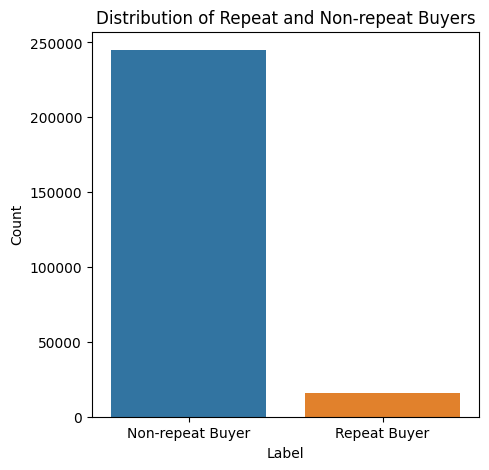

In [8]:
plt.figure(figsize=(5, 5))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Repeat and Non-repeat Buyers')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-repeat Buyer', 'Repeat Buyer'])
plt.show()

In [9]:
merged_data = pd.merge(user_logs, user_profile, on='user_id', how='left')
merged_data.head()

user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type  \
0   219316      472     737        801    5890.0        1018            0   
1    69247      471    1266       4614    4331.0         619            2   
2    69247      471    1266       4614    4331.0         619            0   
3   216952      352     991       3527     869.0         626            0   
4   216952      352     991       3527     869.0         626            0   

   age_range  gender  
0        4.0     0.0  
1        4.0     1.0  
2        4.0     1.0  
3        5.0     2.0  
4        5.0     2.0

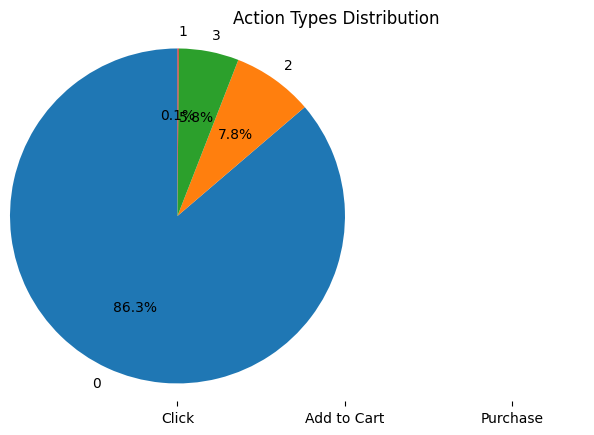

In [10]:
action_counts = merged_data['action_type'].value_counts()
plt.pie(action_counts, labels=action_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Action Types Distribution")
plt.xticks([0, 1, 2, 3], ['Click', 'Add to Cart', 'Purchase', 'Add to Favourite'])
plt.show()

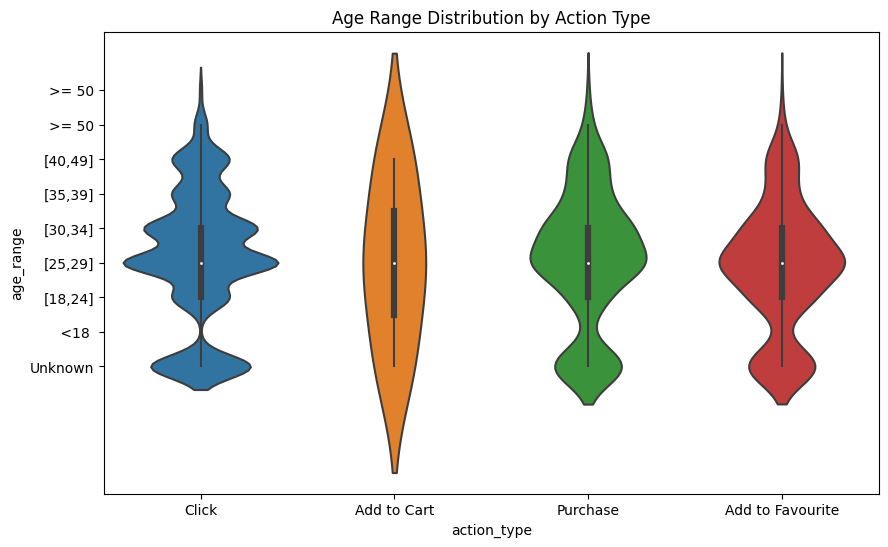

In [11]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='action_type', y='age_range', data=merged_data)
plt.xticks([0, 1, 2, 3], ['Click', 'Add to Cart', 'Purchase', 'Add to Favourite'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ["Unknown", " <18 ", "[18,24]", "[25,29]", "[30,34]", "[35,39]", "[40,49]", ">= 50", ">= 50"])
plt.title("Age Range Distribution by Action Type")
plt.show()

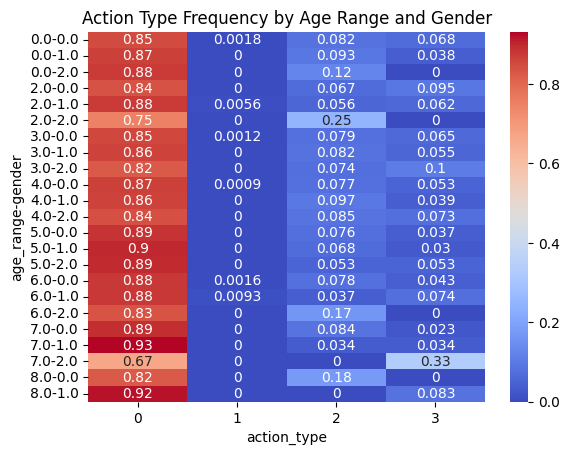

In [12]:
age_gender_action = merged_data.groupby(['age_range', 'gender', 'action_type']).size().unstack()
age_gender_action.fillna(0, inplace=True)

# Normalize the data
age_gender_action = age_gender_action.div(age_gender_action.sum(axis=1), axis=0)

sns.heatmap(age_gender_action, annot=True, cmap='coolwarm')
plt.title("Action Type Frequency by Age Range and Gender")
plt.show()

# Feature engineering 

# Dataset statistics and feature ranking

In [13]:
# There are no duplicate records for action type ==3
user_logs2=user_logs[user_logs['action_type']==3]
user_logs2.duplicated().sum()

0

In [14]:
#Grouping by seller_id
user_logs.groupby('seller_id').size().to_frame().reset_index()

seller_id   0
0           20   3
1           28  15
2           59   1
3           99   1
4          121  12
..         ...  ..
141       4769   4
142       4790  14
143       4801  65
144       4834  60
145       4964   5

[146 rows x 2 columns]

In [15]:
#Seller_id which is popular i.e widely reacheable to the  people
seller_bygroup=user_logs.groupby('seller_id').size()
print("Most popular seller Id : "+ str(seller_bygroup.idxmax()))
print("count: "+str(seller_bygroup.max()))

Most popular seller Id : 801
count: 2468


In [16]:
#Seller_id which is least popular
print("Least popular seller Id : "+ str(seller_bygroup.idxmin()))
print("count : "+str(seller_bygroup.min()))

Least popular seller Id : 59
count : 1


In [17]:
# seller id whose products is brought maximum by the users
purchased_df=user_logs[user_logs['action_type']==2]
purchased_seller_bygroup=purchased_df.groupby('seller_id').size()
print("Seller Id who has most bought products: "+ str(purchased_seller_bygroup.idxmax()))
print("count: "+str(purchased_seller_bygroup.max()))


Seller Id who has most bought products: 801
count: 290


In [18]:
#Grouping dataset by action type - (0 :click, 1 :add-to-cart, 2 :purchase, 3 :add-to-favourite)
user_logs.groupby('action_type').size().to_frame().reset_index()

action_type     0
0            0  6385
1            1     9
2            2   579
3            3   429

In [19]:
#Only 9 items were added to the cart by the users
action_type_1=user_logs[user_logs['action_type']==1]
action_type_1

user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type
201    313304      368    1611       1816       NaN        1110            1
552    310350      350     905       2193       NaN        1024            1
962    116100      472     737        801       NaN         923            1
1369   356593      323    1397       3677       NaN        1012            1
2860   222010      371     664        962       NaN        1111            1
3144    71401      368    1611       1816       NaN        1101            1
3150   329040      467     151       1056       NaN        1109            1
6288   417084      365    1213       1364       NaN         915            1
6339   143500      472     737        801       NaN         923            1

In [20]:
#grouping by cat_id
user_logs.groupby('cat_id').size().to_frame().reset_index()

cat_id    0
0        2   68
1       35    1
2       36   67
3       40  111
4       70    1
..     ...  ...
82    1604  161
83    1611  565
84    1643    1
85    1650    2
86    1661   10

[87 rows x 2 columns]

In [21]:
#Products of category id - 737 is widely reachable among people 
category_bygroup=user_logs.groupby('cat_id').size()
print("Most popular Category Id : "+ str(category_bygroup.idxmax()))
print("count: "+str(category_bygroup.max()))

Most popular Category Id : 737
count: 2477


In [22]:
#Products of category id - 35 is is less reachable among people 
print("Less popular Category Id : "+ str(category_bygroup.idxmin()))
print("count: "+str(category_bygroup.min()))

Less popular Category Id : 35
count: 1


In [23]:
#Products of category id - 737 is widely bought by people
purchased_category_bygroup=purchased_df.groupby('cat_id').size()
print("Most bought Category Id : "+ str(purchased_category_bygroup.idxmax()))
print("count: "+str(purchased_category_bygroup.max()))

Most bought Category Id : 737
count: 290


In [24]:
#grouping by brand_id
user_logs.groupby('brand_id').size().to_frame().reset_index()

brand_id    0
0        82.0    1
1        99.0  161
2       202.0    9
3       277.0   47
4       404.0    2
..        ...  ...
144    8216.0    7
145    8282.0    2
146    8296.0   13
147    8353.0  516
148    8424.0   65

[149 rows x 2 columns]

In [25]:
# Brand Id - 5890 is popular among user
brand_bygroup=user_logs.groupby('brand_id').size()
print("Most Popular Brand Id : "+ str(brand_bygroup.idxmax()))
print("count: "+str(brand_bygroup.max()))

Most Popular Brand Id : 5890.0
count: 2466


In [26]:
# Brand Id - 82 is not popular among user
brand_bygroup=user_logs.groupby('brand_id').size()
print("Less popular Brand Id : "+ str(brand_bygroup.idxmin()))
print("count: "+str(brand_bygroup.min()))

Less popular Brand Id : 82.0
count: 1


In [27]:
# Brand Id - 5890 is most brought brand by user
purchased_brand_bygroup=purchased_df.groupby('brand_id').size()
print("Most bought Brand Id : "+ str(purchased_brand_bygroup.idxmax()))
print("count: "+str(purchased_brand_bygroup.max()))

Most bought Brand Id : 5890.0
count: 290


## Training data

In [28]:
#Merging user log and user profile
merge_user_log_user_profile=pd.merge(user_logs,user_profile,on='user_id')

In [29]:
merge_user_log_user_profile.head()

user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type  \
0   219316      472     737        801    5890.0        1018            0   
1    69247      471    1266       4614    4331.0         619            2   
2    69247      471    1266       4614    4331.0         619            0   
3   216952      352     991       3527     869.0         626            0   
4   216952      352     991       3527     869.0         626            0   

   age_range  gender  
0        4.0     0.0  
1        4.0     1.0  
2        4.0     1.0  
3        5.0     2.0  
4        5.0     2.0

In [30]:
merge_user_log_user_profile.shape

(7402, 9)

In [31]:
#Renaming seller_id column to merchant_id
merge_user_log_user_profile = merge_user_log_user_profile.rename(columns={'seller_id': 'merchant_id'})

In [32]:
#Merging merge_user_log_user_profile and training data to create a final training data
final_merged_training_df=pd.merge(merge_user_log_user_profile,train_df,on=['user_id','merchant_id'],)

In [33]:
final_merged_training_df.head(5)

user_id  item_id  cat_id  merchant_id  brand_id  time_stamp  action_type  \
0   190023      424     662         3432    5093.0        1111            0   
1   190023      424     662         3432    5093.0        1111            0   
2   190023      424     662         3432    5093.0        1111            0   
3   190023      424     662         3432    5093.0        1111            3   
4   190023      424     662         3432    5093.0        1111            2   

   age_range  gender  label  
0        4.0     0.0      0  
1        4.0     0.0      0  
2        4.0     0.0      0  
3        4.0     0.0      0  
4        4.0     0.0      0

In [34]:
final_merged_training_df.shape

(390, 10)

In [35]:
category_final_bygroup=final_merged_training_df.groupby('cat_id').size()
category_final_bygroup.to_frame().reset_index()

cat_id    0
0       40    4
1      151   71
2      184    3
3      302    2
4      384    3
5      407    1
6      420   18
7      469   13
8      656    1
9      662  122
10     664    3
11     786   19
12     821    2
13     946    5
14     992    5
15    1174    1
16    1188    3
17    1208    1
18    1256    6
19    1266    3
20    1290    1
21    1388    4
22    1438    4
23    1505    1
24    1611   93
25    1661    1

In [36]:
brand_final_bygroup=final_merged_training_df.groupby('brand_id').size()
brand_final_bygroup.to_frame().reset_index()

brand_id    0
0      277.0    4
1     1214.0    4
2     1292.0    3
3     1439.0   71
4     1766.0    2
5     2044.0   93
6     2095.0    5
7     2153.0   13
8     2276.0    1
9     2337.0    3
10    2773.0    1
11    3188.0   16
12    3563.0    1
13    3749.0    1
14    4131.0    3
15    4331.0    3
16    4337.0    3
17    4471.0    3
18    4485.0    1
19    5052.0    3
20    5093.0  122
21    6109.0    5
22    6437.0    1
23    6439.0    2
24    7626.0    1
25    7628.0    4
26    7734.0    1
27    7744.0    1
28    7936.0   13
29    8123.0    6

In [37]:
timestamp_final_bygroup=final_merged_training_df.groupby('time_stamp').size()
timestamp_final_bygroup.to_frame().reset_index()

time_stamp    0
0          611    1
1          621    1
2          718    1
3          807    1
4          824    1
5          827    1
6          828    1
7          912    3
8          917    1
9          927    1
10         930    2
11        1001    2
12        1003    1
13        1011    2
14        1014    2
15        1015    1
16        1016    1
17        1024    3
18        1025    3
19        1026    1
20        1028    3
21        1029    3
22        1101    5
23        1102    6
24        1103    4
25        1104   11
26        1105    8
27        1106    9
28        1107    9
29        1108   12
30        1109   18
31        1110   32
32        1111  240

In [38]:
agerange_final_bygroup=final_merged_training_df.groupby('age_range').size()
agerange_final_bygroup.to_frame().reset_index()

age_range    0
0        0.0  100
1        2.0   25
2        3.0   99
3        4.0   70
4        5.0   20
5        6.0   61
6        7.0   12
7        8.0    3

In [39]:
gender_final_bygroup=final_merged_training_df.groupby('gender').size()
gender_final_bygroup.to_frame().reset_index()

gender    0
0     0.0  252
1     1.0  129
2     2.0    7

## Feature Selection 

<b>What is Feature Selection in Machine Learning?</b>

The goal of feature selection techniques in machine learning is to find the best set of features that allows one to build optimized models of studied phenomena.

<b>What are the three steps in feature selection?<b>
    
- Data Preprocessing: Clean and prepare the data for feature selection.
    
- Feature Scoring: Compute scores for each feature to reflect its importance to the target variable.
    
- Selection: Select a subset of the most important features based on their scores, and use them for training the predictive model.
    
<b>What are the different types of feature selection techniques?</b>
- Filter Methods: Select features based on statistical measures such as correlation or chi-squared test.For example- Correlation-based Feature Selection, chi2 test, SelectKBest, and ANOVA F-value.
- Wrapper Methods: Select features by evaluating their combinations using a predictive model.For example- Recursive Feature Elimination, Backward Feature Elimination, Forward Feature Selection
- Embedded Methods: Select features by learning their importance during model training.For example- Lasso Regression, Ridge Regression, and Random Forest.
- Hybrid Methods: Combine the strengths of filter and wrapper methods. For Example- SelectFromModel
- Dimensionality Reduction Techniques: Reduce the dimensionality of the dataset and select the most important features. For Example- pca, lda, and ica.

In [40]:
#droping record with NaN value
final_merged_training_df=final_merged_training_df.dropna()

In [41]:
from sklearn.feature_selection import mutual_info_classif
X=final_merged_training_df.iloc[:,:-1]
Y=final_merged_training_df.iloc[:,-1:]

<b>Information Gain</b>

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.    

C:\Users\seanl\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


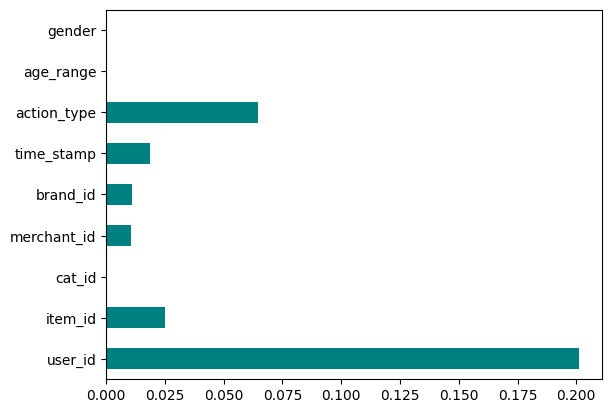

In [42]:
importances=mutual_info_classif(X,Y)
feature_importances=pd.Series(importances,final_merged_training_df.columns[0:len(final_merged_training_df.columns)-1])
feature_importances.plot(kind='barh',color='teal')
plt.show()

<b>Fischer Score</b>

Fisher score is one of the most widely used supervised feature selection methods. The algorithm we will use returns the ranks of the variables based on the fisher’s score in descending order. We can then select the variables as per the case.

In [43]:
!pip install skfeature-chappers


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 66.3/66.3 kB 1.2 MB/s eta 0:00:00


In [44]:
from skfeature.function.similarity_based import fisher_score
x_train=X.to_numpy()
y_train=Y.to_numpy()
ranks1 = fisher_score.fisher_score(x_train, y_train,mode='rank')
feat_importances=pd.Series(ranks,final_merged_training_df.columns[0:len(final_merged_training_df.columns)-1])
feat_importances.plot(kind='barh',color='teal')
plt.show()

UnboundLocalError: local variable 'row' referenced before assignment

<b> Correlation Coefficient</b>

Correlation is a measure of the linear relationship between 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that good variables correlate highly with the target. Furthermore, variables should be correlated with the target but uncorrelated among themselves.

In [ ]:
cor=final_merged_training_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(cor,annot=True)

In [ ]:
#!pip install mlxtend

<b>Exhaustive Feature Selection</b>

This is the most robust feature selection method covered so far. This is a brute-force evaluation of each feature subset. This means it tries every possible combination of the variables and returns the best-performing subset.

In [ ]:
from mlxtend.feature_selection import *
from sklearn.ensemble import RandomForestClassifier
# create the ExhaustiveFeatureSelector object.
efs = ExhaustiveFeatureSelector (RandomForestClassifier (),min_features=4,max_features=8,scoring='roc_auc',cv=2)

In [ ]:
efs = efs.fit (X, Y)

In [ ]:
#print selected features
selected_features = final_merged_training_df.columns[list(efs.best_idx_)]
print(selected_features)

In [ ]:
# print the final prediction score.
print(efs.best_score_)

<b>Random Forest Importance</b>

Random Forests is a kind of Bagging Algorithm that aggregates a specified number of decision trees. The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in other words, a decrease in the impurity (Gini impurity) over all trees. Nodes with the greatest decrease in impurity happen at the start of the trees, while nodes with the least decrease in impurity occur at the end of the trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#create the random forest with your hyperparameters.
model = RandomForestClassifier (n_estimators=140)
# fit the model to start training.
model.fit(X, Y)

In [ ]:
#get the importance of the resulting features.
importances = model. feature_importances_
# create a data frame for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances" : importances})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances')
# plot the feature importances in bars.
final_df.plot.bar(color = 'teal')

### PCA (Principal Component Analysis)

PCA is a dimensionality reduction approach that converts a dataset’s columns into a new group of characteristics called Principal Components (PCs). The variance in a column is the information contained in it. The main aim of Principal Components is to express data in the smallest number of columns possible.

PCA is a process for reducing the complexity of high-dimensional data while preserving trends and patterns. It accomplishes this by condensing the data into fewer components, which can be assumed as feature summaries.

Components are unrelated features that are composites of the original features. They are also assigned so that the first has the most variance in the data, the second for the second most variance, and so on.

PCA is highly beneficial when working with large data sets with many characteristics. Image processing and genomic research are two examples of typical applications that deal with hundreds, if not tens of thousands, of columns.

# Prediction model 

In [ ]:
import pandas as pd
df = pd.read_csv("./Dataset/train_format1.csv")

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split


# Assuming that 'target' is the name of the column containing the target variable
X = df.drop('label', axis=1)
y = df['label']

# Split the data into train and test sets with a 80:20 ratio
train, test = train_test_split(df, test_size=0.2)
train_X, train_y = train.drop('label', axis=1), train['label']
test_X, test_y = test.drop('label', axis=1), test['label']


# X is the input features and y is the target variable
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

In [ ]:
# Correlated features need to be removed
import numpy as np

# X is the input features
corr_matrix = np.corrcoef(X, rowvar=False)
corr_matrix[np.isnan(corr_matrix)] = 0

# Remove highly correlated features
features_to_keep = set(range(X.shape[1]))
for i in range(X.shape[1]):
    for j in range(i):
        if corr_matrix[i, j] > 0.9:
            if selector.scores_[i] > selector.scores_[j]:
                features_to_keep.discard(j)
            else:
                features_to_keep.discard(i)
X_new = X[:, list(features_to_keep)]


In [ ]:
#bayes classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X is the input features and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)


# Model evaluation 